# Machine Learning per la previsione delle serie temporali (*time series*)

In [2]:
# Importazione dei package necessari
from pathlib import Path
import datetime

import pandas as pd
import matplotlib.pylab as plt
import statsmodels.formula.api as sm     # per costruire i modelli
from statsmodels.tsa import tsatools     # il modello per Time Series Analysis (TSA)

import math
import numpy  

%matplotlib inline

In [3]:
# il package 'dmba' contiene diverse utilità; è presente nel PPI (Python Package Index) e può quindi essere installato
# con il comando: 'pip install dmba' (da anaconda prompt) 
import dmba                          # la load in memoria dopo l'install
from dmba import regressionSummary   # un'utile sintesi degli output del metodo di regressione


Il codice del package 'dmba' è visibile e mantenuto dall'autore a [questo link github](https://github.com/gedeck/dmba)

## Cos'è la gestione delle serie storiche (temporali)
Le tecniche di ML si occupano normalmente di **dati sezionali** (*cross-sectional*) [dati dello stesso periodo di tempo o senza considerare le differenze temporali].

Nella gestione delle serie storiche, invece, **il tempo** è un fattore trattato in modo <u>differente</u> dalle altre variabili.
Si parla di analisi **longitudinale**.

**Due tipi** di "gestione" delle serie storiche: 
* **Analisi** delle serie temporali (o storiche), riferita al <u>passato</u> (detta spesso **TSA** = Time Series Analysis)
* **Forecasting**, riferito al <u>futuro</u> (detta spesso **TSF** = Time Series Forecasting).

TSA individua trend, relazioni, pattern stagionali e fattori esterni (driver) della serie storica.
Il forecasting (TSF) invece prevede i valori FUTURI della serie storica. [nb. Forecasting <> Prediction].
TSA è Machine Learning **descrittivo** (od esplorativo), TSF è Machine Learning **predittivo**.
I metodi di ML che si usano per TSA sono quindi diversi da quelli che si usano per il TSF.
I metodi di TSA, infatti, cercano di <u>capire e spiegare</u>; quelli di TSF sono spesso <u>"black box"</u>.
I metodi di TSA, inoltre, sono retrospettivi (guardano al passato), quelli di TSF sono prospettici (guardano al futuro).
--> in questo corso vedremo esempi sia di TSA che di TSF.

In questo corso tratteremo <u>le serie storiche "singole"</u>, le più comuni e semplici.
[esempio di serie storica **multipla**: le vendite mensili di diversi prodotti].
Le serie storiche singole NON gestiscono le possibili interazioni; la gestione di queste interazioni, tuttavia, richiede assunzioni restrittive e competenze statistiche più avanzate.

## Le componenti di una serie storica
Una serie storica ha **5 componenti**:
* il <u>livello medio</u> della serie;
* il <u>trend</u>: come la serie cambia nel tempo;
* la <u>stagionalità</u>: gli eventuali comportamenti ciclici (all'interno dell'intervallo temporale ossevato): non è necessariamente la stagione dell'anno.
* il <u>rumore</u> (*noise*): la variazione casuale (per errori di misurazione od altri fattori non considerati). E' sempre presente, in qualche misura ([esempio con scala differente](componenti_TS.png));
* <u>auto-correlazione</u>.

[Trend vs Pattern](https://www.investopedia.com/ask/answers/010715/what-are-differences-between-patterns-and-trends.asp):<br>
*A trend is the **general direction** of a price/quantity over a period of time. A pattern is a set of data that follows **a recognizable form**, which analysts then attempt to find in the current data.*

Useremo la serie temporale di [Amtrak](https://www.amtrak.com/home)


In [4]:
Amtrak_df = pd.read_csv('Amtrak.csv') # Amtrak è una compagnia ferroviaria americana che colleziona con regolarità i dati 
                                      # relativi ai passeggeri. Il periodo collezionato è GEN91 - MAR04 (159 mesi, 
                                      # quasi 14 anni). E' dunque una serie MENSILE (cioè, lo step o periodo è il mese)
                                      # Il dataset è pubblico: www.forecastingprinciples.com --> "Data" --> "T-Competition Data"
                                      # --> click su 'time-series data').

# Amtrak_df = dmba.load_data('Amtrak.csv') # alternativa

print(Amtrak_df,'\n')    # --> i dati sono ora organizzati in modo matriciale: per anno (stagione) e per mese (la frequenza).
                         #     '\n' aggiunge solo una linea vuota per separare i diversi output delle 'print'.
print(Amtrak_df.info())  # --> 'Month' è una stringa ('object') [attenzione: sono tutti oggetti!]

          Month  Ridership
0    01/01/1991   1708.917
1    01/02/1991   1620.586
2    01/03/1991   1972.715
3    01/04/1991   1811.665
4    01/05/1991   1974.964
..          ...        ...
154  01/11/2003   2076.054
155  01/12/2003   2140.677
156  01/01/2004   1831.508
157  01/02/2004   1838.006
158  01/03/2004   2132.446

[159 rows x 2 columns] 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159 entries, 0 to 158
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Month      159 non-null    object 
 1   Ridership  159 non-null    float64
dtypes: float64(1), object(1)
memory usage: 2.6+ KB
None


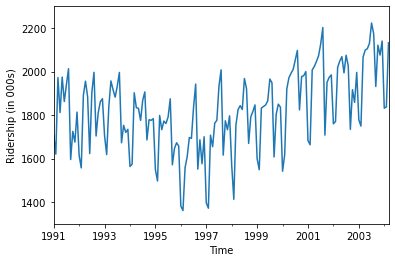

In [5]:
# Per identificare le componenti di una serie temporale per prima cosa si esamina il plot della serie completa.
# E' un 'line chart' dei valori della serie nel tempo, con le etichette temporali in ascissa.
# [Il nostro scopo finale, come TSF, sarà di prevedere i passeggeri di APR04, ecc il primo mese fuori serie.]

# convertiamo la data da stringa (object) a 'datetime' (manipolabile):
Amtrak_df['Date'] = pd.to_datetime(Amtrak_df.Month, format='%d/%m/%Y')

# convertiamo la colonna del dataframe in un oggetto 'Series' (l'argomento 'name' è usato per dare un nome alla serie)
ridership_ts = pd.Series(Amtrak_df.Ridership.values, index=Amtrak_df.Date, name='Ridership')

# definiamo la frequenza della serie:
ridership_ts.index = pd.DatetimeIndex(ridership_ts.index, freq=ridership_ts.index.inferred_freq)

# plot della serie:
ax = ridership_ts.plot()
ax.set_xlabel('Time')
# ax.set_yscale('log') # [se si vuole la y logaritmica]
ax.set_ylabel('Ridership (in 000s)')
_ = ax.set_ylim(1300, 2300)

plt.show()   # --> il "livello" (la media generale della serie) sembra intorno a 1.800K al mese;
             # c'è una leggera forma generale ad U ("U-shape), con una pronunciata stagionalità annuale,
             # con picco dei viaggi in estate (luglio ed agosto);
            
             # attenzione: la variabile in ascissa (gli indici temporali della serie) sono per definizione DISCRETI.
             # La serie appare come CONTINUA solo perchè, per comodità, si sceglie in genere un 'line-chart', che 
             # appunto collega tutti i valori della serie con una linea.
             # Cioè, in altre parole, questo grafico NON è come il pennino di un sismografo, che traccia una linea
             # effettivamente continua.

In [6]:
ridership_ts.mean() # la media della serie

1822.197207547169

### Nota sui tool grafici
Per esaminare più attentamente una serie storica (in modo grafico) sono molto utili questi strumenti:
* **zoom**: particolarmente utile con serie lunghe: può infatti rivelare pattern locali prima nascosti (vedi prossime celle);
* **cambio di scala**: ad es. il logaritmo per linearizzare / compattare un [andamento esponenziale](https://it.wikipedia.org/wiki/Funzione_esponenziale) [si usa *ax.set_yscale('log')*]; se il trend nella nuova scala sembra più o meno lineare significa allora che il trend nella vecchia scala è circa esponenziale ([esempio nella terza sezione](https://www.graphpad.com/guides/prism/latest/user-guide/when_to_use_a_logarithmic_axis.htm)); attenzione a [questa differenza](https://www.researchgate.net/figure/Comparison-of-exponential-and-logistic-growth_fig4_262891745), ad esempio nella diffusione pandemica;
* **aggiunta di linea di trend**: è un'altra possibilità per meglio individuare l'andamento indicativo della serie, quello che meglio si adatta (*fitting*) ai dati ([vedi qui](Shapes.png));
* **soppressione della stagionalità**, ad es. a) aggregando i dati, oppure b) creando serie/plot differenti per ogni stagionalità, oppure c) ancora usando un diagramma a media mobile (lo vedremo più avanti); la soppressione della stagionalità spesso aiuta ad identificare meglio gli eventuali trend / pattern della serie;
 
Sospendiamo un attimo l'analisi di *Amtrak* ed utilizziamo un altro dataset più adatto per questa dimostrazione;<br>
Sono i passaggi GIORNALIERI sotto il tunnel svizzero di [Baregg](https://en.wikipedia.org/wiki/Baregg_Tunnel).<br>
Qui lo step o periodo è il giorno.

In [7]:
# l'esame del dataset
baregg_df = dmba.load_data('BareggTunnel.csv') # import con la utility di 'dmba', questa volta
print(baregg_df.shape,'\n')
print(type(baregg_df),'\n')
print(baregg_df,'\n')
print(baregg_df.info(),'\n') # --> è una stringa

(747, 2) 

<class 'pandas.core.frame.DataFrame'> 

             Day  Number of vehicles
0    01 Nov 2003              103536
1    02 Nov 2003               92051
2    03 Nov 2003              100795
3    04 Nov 2003              102352
4    05 Nov 2003              106569
..           ...                 ...
742  12 Nov 2005              104646
743  13 Nov 2005               94424
744  14 Nov 2005              112165
745  15 Nov 2005              114296
746  16 Nov 2005              114690

[747 rows x 2 columns] 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 747 entries, 0 to 746
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Day                 747 non-null    object
 1   Number of vehicles  747 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 11.8+ KB
None 



In [8]:
# conversione della data da oggetto stringa ('object data type') ad oggetto 'datetime':
baregg_df['Date'] = pd.to_datetime(baregg_df.Day, format='%d %b %Y')

# creazione della serie PIENA (senza visualizzazione):
vehicles_ts = pd.Series(baregg_df['Number of vehicles'].values, index=baregg_df.Date, name='Vehicles')

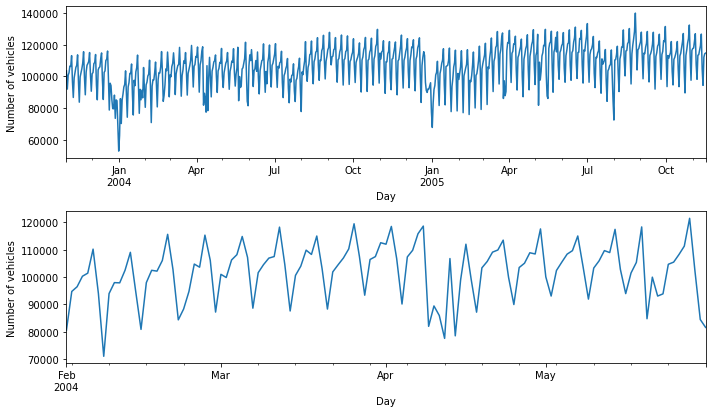

In [9]:
# come detto, un tipico secondo passo, dopo il line-chart generale, è lo ZOOM;
# creiamo una serie PIU' RISTRETTA di questo dataset (zooming-in): una sotto-serie di 4 mesi:

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10,6)) 

                         # 'fig, ax' è molto frequente in matplotlib.
                         # da stackoverflow (post 34162443): "plt.subplots() is a function that returns a tuple containing a 
                         # figure and axes object(s). Thus when using:
                         #     'fig, ax = plt.subplots()'
                         # you unpack this tuple into the variables 'fig' and 'ax'. Having 'fig' is useful if you want to change
                         # figure-level attributes or save the figure as an image file later, e.g. with:
                         #     'fig.savefig('yourfilename.png'). 
                         # You maybe don't have to use the returned figure object but many people do use it later so it's common
                         # to see it. 
                         # Also, all axes objects (the objects that have plotting methods), have a parent figure object anyway, 
                         # thus: 
                         #     'fig, ax = plt.subplots()' 
                         # is more concise than: 
                         #     'fig = plt.figure()'
                         #     'ax = fig.add_subplot(111)
                         # If you want 4 graphs, you could have ax11, ax12, ax21, ax22 by using:
                         #     'fig.add_subplot(221)'
                         # or 222, 223, 224 respectively.


vehicles_ts.plot(ax=axes[0])
axes[0].set_xlabel('Day')
axes[0].set_ylabel('Number of vehicles')
vehicles_ts['2004-02-01':'2004-05-31'].plot(ax=axes[1]) # <-- la serie ristretta di 4 mesi 
axes[1].set_xlabel('Day')
axes[1].set_ylabel('Number of vehicles')
plt.suptitle('')    # Suppress the overall title
plt.tight_layout()  # Increase the separation between the plots

plt.show() # --> si nota nello zoom (secondo plot) un chiaro pattern sul giorno della settimana, non visibile sul chart
           #     generale (dei 2 anni).

### Zoom e fit quadratico
Torniamo al dataset Amtrak.<br>
**Possiamo assumere** ora che il trend sia (abbastanza) **LINEARE** (nel periodo osservato e nei primi mesi successivi oggetto di forecasting) ed il rumore sia [**GAUSSIANO**](https://it.wikipedia.org/wiki/Distribuzione_normale) [e quindi, la casualità abbastanza simmetrica]. In questo caso, possiamo allora usare una **regressione lineare OLS (OLS=Ordinary Least Squares)** per prevedere i prossimi passaggi (un'altra tecnica di Forecasting è lo *smoothing*, che vedremo più avanti).<br>
Poichè il plot generale della serie intera mostra un leggero andamento ad U, è probabilmente meglio utilizzare una regressione **polinomiale (quadratica)** per fittare il trend. Si noti che l'equazione di regressione, in questo caso, è ancora lineare perchè le variabili del problema di ottimizzazione non sono i predittori (*trend*, *trend^2*) ma i coefficienti beta-i. 

In [10]:
# creiamo una serie più ristretta (zooming-in), con tre anni da Jan 1997 a Dec 1999, tramite SLICING: 
ridership_ts_3yrs = ridership_ts['1997':'1999']

print(type(ridership_ts_3yrs))  # è una 'Series'

# creiamo un data-frame con alcune colonne in più: un termine costante, un termine di trend ed un termine quadratico di trend;
# la funzione 'add_trend' "Adds a trend and/or constant to an array" (dall'help online).

ridership_df = tsatools.add_trend(ridership_ts, trend='ctt')  # dall'help on-line (premere shift+tab dopo aver posizionato
                                                              # il cursore ALL'INTERNO delle parentesi della funzione):
                                                              # --> 'ctt' adds constant and linear and quadratic trend.
                                                              # NB: La costante (intercetta) è in genere consigliabile.

print('\n',ridership_df)                                      # --> dall'help on-line: "The original data with the additional 
                                                              # trend columns. If x is a pandas 'Series' or 'DataFrame', then 
                                                              # the trend column names are ‘const’, ‘trend’ and ‘trend_squared’.
                                                              # Returns columns as ['ctt','ct','c'] whenever applicable. There 
                                                              # is currently no checking for an existing trend.
                
                                                              # E', per certi versi, il metodo di CREAZIONE dell'ISTANZA con la
                                                              # sua struttura.
                                                              # La successiva funzione 'sm.ols.fit' richiede infatti in input
                                                              # un dataframe [NON è lo standard scikit-learn!]

<class 'pandas.core.series.Series'>

             Ridership  const  trend  trend_squared
Date                                              
1991-01-01   1708.917    1.0    1.0            1.0
1991-02-01   1620.586    1.0    2.0            4.0
1991-03-01   1972.715    1.0    3.0            9.0
1991-04-01   1811.665    1.0    4.0           16.0
1991-05-01   1974.964    1.0    5.0           25.0
...               ...    ...    ...            ...
2003-11-01   2076.054    1.0  155.0        24025.0
2003-12-01   2140.677    1.0  156.0        24336.0
2004-01-01   1831.508    1.0  157.0        24649.0
2004-02-01   1838.006    1.0  158.0        24964.0
2004-03-01   2132.446    1.0  159.0        25281.0

[159 rows x 4 columns]


C:\Users\Utente\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [11]:
# fittiamo ora un modello di regressione lineare OLS alla serie INTERA --> NON si usa lo stimatore generico 'LinearRegression'!!
# la funzione 'add_trend' "Creates a Model from a formula and dataframe".
ridership_lm = sm.ols(formula='Ridership ~ trend + trend_squared', data=ridership_df).fit() # 
                                                      # NB. Un modello di regressione è 'lineare' rispetto ai coefficienti,
                                                      # non rispetto alle variabili (qui, 'trend' alle varie potenze).

# alternativa, senza la 'add_trend': DMBA, p. 429-430]:
ridership_lm = sm.ols(formula='Ridership ~ trend + np.square(trend)', data=ridership_df).fit() # 
        
type(ridership_lm)

statsmodels.regression.linear_model.RegressionResultsWrapper

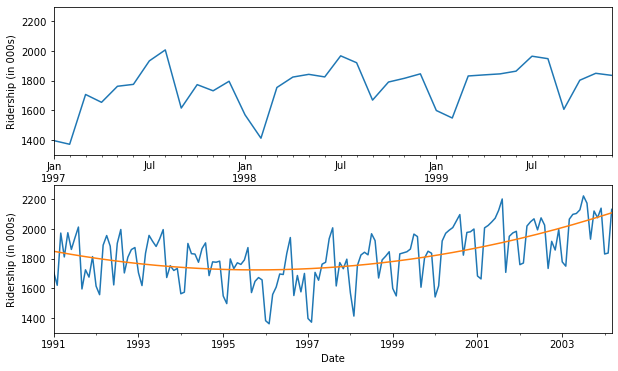

In [12]:
# ora visualizziamo: a) la serie ridotta (zoommata) e b) la serie piena con la linea di trend sovrapposta (2 subplot):
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10,6))
ridership_ts_3yrs.plot(ax=axes[0]) # la serie ridotta
ridership_ts.plot(ax=axes[1])      # la serie piena
for ax in axes:
    ax.set_xlabel('Date')                            # la stessa label di ascissa per i due plot
    ax.set_ylabel('Ridership (in 000s)')             # la stessa label di ordinata per i due plot
    ax.set_ylim(1300, 2300)                          # gli stessi limiti di valori in ordinata per i due plot
ridership_lm.predict(ridership_df).plot(ax=axes[1])  # le previsioni con l'oggetto sopra creato e fittato.
                                                     # Si noti il tipico pipeling dei metodi (in cascata).

plt.show()                                           # --> I due grafici aiutano a rendere le componenti più visibili.

                                                     # --> La serie ha una FORTE stagionalità estiva.

L'ultima componente da esaminare è l'[auto-correlazione](Autocorrelation.png), che riprenderemo meglio nella seconda giornata del corso.<br>
Da notare, comunque, che questa auto-correlazione, come si vede bene nel grafico, non è una stagionalità perchè:
* il t0 di inizio del ciclo (di decadimento) è irregolare (non prevedibile);
* il pattern ciclico (il decadimento) ha forme differenti tra loro.

### Riassunto sulle componenti
E' davvero importante imparare a riconoscere i pattern di time-series più diffusi, perchè i metodi di Machine Learning che si applicano sono differenti.<br>
Attenzione: si tratta comunque sempre di valutazioni in parte **soggettive**.<br>

[I trend e le stagionalità GLOBALI più comuni (Galit Shmueli - Axelrod Schnall Publishers - 2016)](Common_patterns_shmueli.png)<br>

[Video riassuntivo sui pattern (da *coursera*)](https://www.youtube.com/watch?v=_z-a6WoNC2s&t=131s)<br>

[Le slide del video precedente - parte 1](Common_patterns_in_TS.png)<br>
[Le slide del video precedente - parte 2](Common_patterns_in_TS_2.png)<br>
[Le slide del video precedente - parte 3](Common_patterns_in_TS_3.png)<br>
[Le slide del video precedente - parte 4](Common_patterns_in_TS_4.png)<br>

## Metodi di forecasting (*ML predittivo*)
**Note**:
* <u>parametrici</u> (diretti): fanno delle **assunzioni** sulle componenti della serie, ad esempio che il trend in un certo periodo è lineare od esponenziale; oppure che il rumore è [gaussiano](https://en.wikipedia.org/wiki/Gaussian_noise#:~:text=Gaussian%20noise%2C%20named%20after%20Carl,take%20on%20are%20Gaussian%2Ddistributed.);
* i metodi parametrici funzionano molto bene se le assunzioni sono (abbastanza) vere;
* altrimenti si usano metodi <u>non-parametrici</u>, anche detti *distribution-free* oppure *data-driven*, che fanno meno assunzioni sulla struttura delle componenti della serie;
* i metodi non-parametrici sono utili appunto quando le assunzioni probabilmente non sono soddisfatte oppure quando <u>il comportamento della serie cambia nel tempo</u>; sono inoltre semplici e computazionalmente veloci, tuttavia richiedono molti dati;
* un **criterio importante** per decidere quale tipo di metodo di forecasting usare è la presenza di pattern globali (cioè che sono abbastanza costanti su tutta la serie) oppure [locali](https://www.researchgate.net/figure/A-shapelet-red-dotted-line-capturing-a-local-pattern-of-a-time-series-blue-solid_fig2_331532370), che cioè avvengono solo in un breve periodo della serie;
* attenzione: non confondere i pattern locali con [le sotto-popolazioni](Patterns.png);
* se i pattern della serie sono globali, i metodi parametrici sono preferibili perchè usano tutti i dati disponibili;
* se i pattern sono locali, al contrario, il metodo parametrico dovrebbe essere applicato ad ogni differente sottosezione della serie, che non è pratico e spesso non noto;
* i pattern locali **imparano** il pattern dai dati, e la loro <u>memoria</u> (l'ampiezza del periodo al quale si applicano) può essere lunga (per pattern che cambiano lentamente nel tempo) oppure breve (per pattern dinamici nel tempo).


**I plot visti sopra servono non solo ad identificare meglio le componenti, ma anche a decidere se la natura di trend/pattern/stagionalità è <u>locale o globale</u>**.

Le serie temporali [*white noise*](https://machinelearningmastery.com/white-noise-time-series-python/#:~:text=A%20time%20series%20is%20white%20noise%20if%20the%20variables%20are,with%20a%20mean%20of%20zero.&text=If%20the%20variables%20in%20the,is%20called%20Gaussian%20white%20noise.) **non sono prevedibili** perchè puramente casuali. Vedi [esempio](White_noise.png).

## Partizionamento dei dati e previsione (*forecast*)
Come per tutti i metodi di ML *predittivo*, occorre per prima cosa suddividere il dataset in **training** set, sul quale si allena il modello, e **test set (o validation set**), sul quale lo si valuta. Le previsioni saranno poi fatte per i **valori futuri**.<br>

[In generale](https://en.wikipedia.org/wiki/Training,_validation,_and_test_sets); ci sono delle peculiarità delle serie temporali che vedremo più avanti.<br>

[La regola del pollice di Hastie & Tibshirani](Percentuali_partizionamento.png)

In [13]:
# split dati in periodo di training e periodo di validazione (=test!) del modello (SUCCESSIVI per le serie temporali):

nValid = 36                           # periodo di validazione (test): gli ultimi 36 mesi della serie (22%) 
                                      # (da Aprile 2001 a Marzo 2004); 
                                      # non c'è casualità (e quindi non serve un seme).

nTrain = len(ridership_ts) - nValid   # periodo di training: i 123 mesi precedenti (da Gennaio 1991 a marzo 2001).
                                      # [la serie totale è di 159 mesi --> 159-36 = 123.]
    
# partizionamento dei dati [vedi tecniche di subsetting di python e pandas]:
train_ts = ridership_ts[:nTrain]    # subsetting: tutti gli elementi della serie sino a 'nTrain'-1; 
valid_ts = ridership_ts[nTrain:]    #    "          "                            da 'nTrain' in poi;
                                    # --> regole di subsetting delle 'Series' coerenti con quelle dei 'dataframe'.
print(train_ts.shape)
print(valid_ts.shape)

# --> ESAME variabili (nome, tipo, shape, valore, ecc) con il Variable Inspector

(123,)
(36,)


In [33]:
print(valid_ts)

Date
2001-04-01    2023.792
2001-05-01    2047.008
2001-06-01    2072.913
2001-07-01    2126.717
2001-08-01    2202.638
2001-09-01    1707.693
2001-10-01    1950.716
2001-11-01    1973.614
2001-12-01    1984.729
2002-01-01    1759.629
2002-02-01    1770.595
2002-03-01    2019.912
2002-04-01    2048.398
2002-05-01    2068.763
2002-06-01    1994.267
2002-07-01    2075.258
2002-08-01    2026.560
2002-09-01    1734.155
2002-10-01    1916.771
2002-11-01    1858.345
2002-12-01    1996.352
2003-01-01    1778.033
2003-02-01    1749.489
2003-03-01    2066.466
2003-04-01    2098.899
2003-05-01    2104.911
2003-06-01    2129.671
2003-07-01    2223.349
2003-08-01    2174.360
2003-09-01    1931.406
2003-10-01    2121.470
2003-11-01    2076.054
2003-12-01    2140.677
2004-01-01    1831.508
2004-02-01    1838.006
2004-03-01    2132.446
Freq: MS, Name: Ridership, dtype: float64


In [14]:
# PROVE di subsetting di 'train_ts' (utili per dopo):
print(train_ts,'\n')       # tutta la serie
print(train_ts[0])         # il primo elemento
print(train_ts[-1])        # l'ultimo elemento
print(train_ts[-2:])       # gli ultimi due elementi

Date
1991-01-01    1708.917
1991-02-01    1620.586
1991-03-01    1972.715
1991-04-01    1811.665
1991-05-01    1974.964
                ...   
2000-11-01    1981.408
2000-12-01    2000.153
2001-01-01    1683.148
2001-02-01    1663.404
2001-03-01    2007.928
Freq: MS, Name: Ridership, Length: 123, dtype: float64 

1708.917
2007.928
Date
2001-02-01    1663.404
2001-03-01    2007.928
Freq: MS, Name: Ridership, dtype: float64


Utilizziamo ora due metodi di forecasting (del prossimo valore futuro) semplici (per imparare) ma spesso efficaci (tant'è che costituiscono un "benchmark" di riferimento non facile da battere):
* **naive forecast**: l'ultimo valore, cioè il valore dell'elemento k+1 della serie (*forecasted*) è semplicemente il valore dell'ultimo elemento k (*actual*);
* **seasonal naive forecast** (stagionale): utile quando la serie presenta delle <u>stagionalità</u>; è l'ultimo valore *simile* nella stagione. Ad esempio: per il forecast di Aprile 2001, *snaive* usa il numero viaggiatori dell'ultimo aprile del set di training (nel 2000). Lo stesso per il forecast di aprile 2002 (il valore di aprile 2000, nuovamente, perchè DENTRO il dataset di training)


In [15]:
# Previsioni con i due metodi:

naive_pred = pd.Series(train_ts[-1], index=valid_ts.index) # --> con 'naive forecast' la previsione è 
                                                           #     semplicemente l'ultimo valore

last_season = train_ts[-12:]                               # gli ultimi 12 valori (la stagionalità da considerare)
seasonal_pred = pd.Series(pd.concat([last_season]*5)[:len(valid_ts)].values, index=valid_ts.index)

print(naive_pred)         # --> 36 valori tutti uguali
print('\n',seasonal_pred)      # --> 36 valori uguali a quello del rispettivo mese dell'ultimo anno ('last_season')

Date
2001-04-01    2007.928
2001-05-01    2007.928
2001-06-01    2007.928
2001-07-01    2007.928
2001-08-01    2007.928
2001-09-01    2007.928
2001-10-01    2007.928
2001-11-01    2007.928
2001-12-01    2007.928
2002-01-01    2007.928
2002-02-01    2007.928
2002-03-01    2007.928
2002-04-01    2007.928
2002-05-01    2007.928
2002-06-01    2007.928
2002-07-01    2007.928
2002-08-01    2007.928
2002-09-01    2007.928
2002-10-01    2007.928
2002-11-01    2007.928
2002-12-01    2007.928
2003-01-01    2007.928
2003-02-01    2007.928
2003-03-01    2007.928
2003-04-01    2007.928
2003-05-01    2007.928
2003-06-01    2007.928
2003-07-01    2007.928
2003-08-01    2007.928
2003-09-01    2007.928
2003-10-01    2007.928
2003-11-01    2007.928
2003-12-01    2007.928
2004-01-01    2007.928
2004-02-01    2007.928
2004-03-01    2007.928
Freq: MS, dtype: float64

 Date
2001-04-01    1971.493
2001-05-01    1992.301
2001-06-01    2009.763
2001-07-01    2053.996
2001-08-01    2097.471
2001-09-01    1823.7

In [16]:
ridership_ts['2000':'2001'] # per verifica

Date
2000-01-01    1541.660
2000-02-01    1616.928
2000-03-01    1919.538
2000-04-01    1971.493
2000-05-01    1992.301
2000-06-01    2009.763
2000-07-01    2053.996
2000-08-01    2097.471
2000-09-01    1823.706
2000-10-01    1976.997
2000-11-01    1981.408
2000-12-01    2000.153
2001-01-01    1683.148
2001-02-01    1663.404
2001-03-01    2007.928
2001-04-01    2023.792
2001-05-01    2047.008
2001-06-01    2072.913
2001-07-01    2126.717
2001-08-01    2202.638
2001-09-01    1707.693
2001-10-01    1950.716
2001-11-01    1973.614
2001-12-01    1984.729
Freq: MS, Name: Ridership, dtype: float64

[Il funzionamento del Seasonal Naive Forecast su questi dataset](SNF_esempio.png)<br>
Il **benchmark base** nel TSF è, come spesso nel ML, la mera MEDIA di tutti i valori.<br>
NF e SNF battono in genere il benchmark base, cioè forniscono previsioni migliori perchè considerano solo il <u>passato</u> (anche se solo quello ultimissimo), e costituiscono quindi il **vero benchmark di riferimento** che gli altri metodi di TSF devono cercare di battere (previsioni ancora migliori).<br>
**Previsione buona/ottima**: il <u>residuo</u>, cioè la differenza tra il valore t+k della serie previsto e quello effettivo, è piccolo. Il residuo è anche detto: *errore di forecast*.<br>
Storicamente, il termine *residuo* è nato per indicare ciò che RESTA dopo l'applicazione (il fit) del modello alla serie, cioè ciò che NON è modellato dal modello stesso, cioò che non è **SPIEGATO** da esso.<br>
Il residuo è riferito alla SINGOLA previsione; i vari residui possono poi essere assemblati in una metrica di valutazione complessiva della bontà predittiva del modello su TUTTA la serie, o comunque su tutto l'intervallo di osservazione scelto.

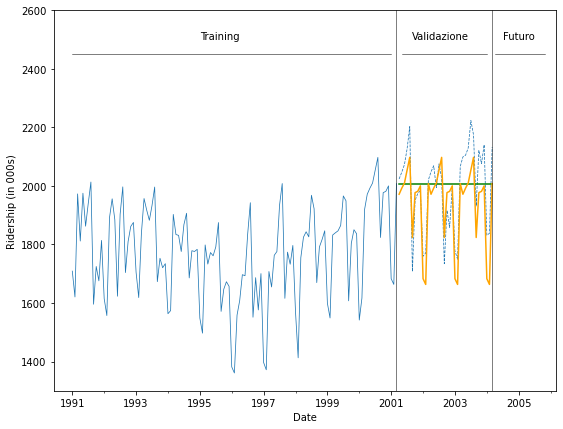

In [17]:
# plot dei forecast e degli actual nel dataset di training ed in quello di validazione:

ax = train_ts.plot(color='C0', linewidth=0.75, figsize=(9,7))
valid_ts.plot(ax=ax, color='C0', linestyle='dashed', linewidth=0.75)
# ax.set_xlim('1990', '2006-06-01')
ax.set_ylim(1300, 2600)
ax.set_xlabel('Time')
ax.set_ylabel('Ridership (in 000s)')

naive_pred.plot(ax=ax, color='green')
seasonal_pred.plot(ax=ax, color='orange')


# Determinare le coordinate per disegnare frecce e linee:
one_month = pd.Timedelta('31 days')
xtrain = (min(train_ts.index), max(train_ts.index) - one_month)
xvalid = (min(valid_ts.index) + one_month, max(valid_ts.index) - one_month)
xfuture = (max(valid_ts.index) + one_month, max(valid_ts.index) + 20 * one_month)
xtv = xtrain[1] + 0.5 * (xvalid[0] - xtrain[1])
xvf = xvalid[1] + 0.5 * (xfuture[0] - xvalid[1])
ax.set_xlim(min(train_ts.index) - 6 * one_month, max(valid_ts.index) + 24 * one_month)

ax.add_line(plt.Line2D(xtrain, (2450, 2450), color='black', linewidth=0.5))
ax.add_line(plt.Line2D(xvalid, (2450, 2450), color='black', linewidth=0.5))
ax.add_line(plt.Line2D(xfuture, (2450, 2450), color='black', linewidth=0.5))
ax.text('1995', 2500, 'Training')
ax.text('2001-9', 2500, 'Validazione')
ax.text('2004-7', 2500, 'Futuro')
ax.axvline(x=xtv, ymin=0, ymax=1, color='black', linewidth=0.5)
ax.axvline(x=xvf, ymin=0, ymax=1, color='black', linewidth=0.5)
plt.show()

                             # --> per il dataset di validazione il grafico mostra:
                             #     * forecast naive, UGUALE per tutti i mesi: la linea verde orizzontale;
                             #     * forecast naive stagionale, VARIABILE: la curva arancione (si noti la ciclicità 
                             #       triennale);
                             #     * i valori effettivi (actual): la curva punteggiata.

## Valutazione della capacità predittiva
Infine, come in tutte le tecniche di ML previsionali (supervisionate), misuriamo **l'accuratezza** dei due metodi naive ora visti, con le metriche delle previsioni numeriche: ME, ROOTED MSE, MAE, ecc.<br>
L'accuratezza si misura sempre e solo sul datset di validazione/test, perchè quello di training è già stato usato per allenare il modello, ed del futuro (nuovi valori della serie da prevedere) invece NON conosciamo il valore effettivo. Invece, lo conosciamo per il dataset di validazione.

Per una definizione in Python delle suddette metriche (anche dette *loss function*) vedi il codice dell'utility *regressionSummary* a questo [indirizzo github](https://github.com/gedeck/dmba) [e poi --> src --> dmba --> metric.py].

In [17]:
regressionSummary(valid_ts, naive_pred)              # il primo argomento è la serie effettiva, il secondo è quella 
                                                     # prevista con forecast naive.


Regression statistics

                      Mean Error (ME) : -14.7177
       Root Mean Squared Error (RMSE) : 142.7551
            Mean Absolute Error (MAE) : 115.9234
          Mean Percentage Error (MPE) : -1.2750
Mean Absolute Percentage Error (MAPE) : 6.0214


In [18]:
regressionSummary(valid_ts, seasonal_pred)           # il primo argomento è la serie effettiva, il secondo è quella 
                                                     # prevista con seasonal forecast naive.


Regression statistics

                      Mean Error (ME) : 54.7296
       Root Mean Squared Error (RMSE) : 95.6243
            Mean Absolute Error (MAE) : 84.0941
          Mean Percentage Error (MPE) : 2.6528
Mean Absolute Percentage Error (MAPE) : 4.2477


In [42]:
np.power(95.6243,2) # --> MSE: non è nella scala della risposta (ridership)

9144.006750490002

**NOTE**:
* poichè il dataset 'Amtrak' ha delle stagionalità mensili, il metodo stagionale (Seasonal Naive Forecast) vince nettamente (sul Naive Forecast) con tutte le metriche; 
* le metriche di "norma-0" possono fornire valori negativi;
* in generale, le metriche di errore di norma-2 (L2 norm, es MSE oppure RMSE), cioè con i quadrati, sono preferibili alle norme-1 (L1-norm, es MAE), cioè i valori assoluti, perchè sempre differenziabili (su tutto il dominio della variabile indipendente).
                            


[Training vs Test error](TS_pred_results.png) --> l'errore sul validation test è più significativo per il futuro.

In [19]:
# Ecco come si calcola l'errore di training:

print('\n','naive model in training set')
regressionSummary(train_ts[1:], train_ts[:-1]) # 

print('\n','seasonal model in training set')
regressionSummary(train_ts[12:], train_ts[:-12])                            


 naive model in training set

Regression statistics

                      Mean Error (ME) : 2.4509
       Root Mean Squared Error (RMSE) : 168.1470
            Mean Absolute Error (MAE) : 125.2975
          Mean Percentage Error (MPE) : -0.3460
Mean Absolute Percentage Error (MAPE) : 7.2714

 seasonal model in training set

Regression statistics

                      Mean Error (ME) : 13.9399
       Root Mean Squared Error (RMSE) : 99.2656
            Mean Absolute Error (MAE) : 82.4920
          Mean Percentage Error (MPE) : 0.5851
Mean Absolute Percentage Error (MAPE) : 4.7153


La metrica di validazione più diffusa per previsioni numeriche è il **rooted mean square error**, [così definito](RMSE.png).

In [20]:
# MSE per il SNF (calcolato con scikit-learn)
from sklearn.metrics import mean_squared_error   # RMSE non è direttamente disponibile
MSE = mean_squared_error(y_true=valid_ts,y_pred=seasonal_pred)  
print("Mean Square Error sk-learn: ",round(MSE,2))

# MSE sempre per il SNF (calcolato con 'numpy'):
MSE_2 = np.square(np.subtract(valid_ts,seasonal_pred)).mean()   # MSE calcolato con 'numpy'
print("Mean Square Error numpy: ",round(MSE_2,2))

RMSE = math.sqrt(MSE)
RMSE_2 = math.sqrt(MSE_2)
print("Root Mean Square Error (scikit-learn): ",round(RMSE,2))
print("Root Mean Square Error (numpy): ",round(RMSE_2,2))

Mean Square Error sk-learn:  9144.01
Mean Square Error numpy:  9144.01
Root Mean Square Error (scikit-learn):  95.62
Root Mean Square Error (numpy):  95.62


In [22]:
# Come utilizzare questi numeri? Per due scopi:
# - confrontare metodi TSF differenti e valutarli comparativamente sul validation set --> il metodo con metrica di errore 
#   (ad es. RMSE) più bassa sarà quello che utilizziamo per le VERE previsioni (valori FUTURI della serie non ancora noti);
# - interpretare i risultati (le previsioni)
seasonal_pred # --> alla luce del RMSE = 95.62) le previsioni fornite dal metodo TSF (qui SNF), elencate per 
              #     comodità qui sotto, sono da intendersi MEDIAMENTE errate per +/- 95.62.
              # --> cioè, in altre parole, 1971.493 è la previsione PUNTUALE per APR-04;
              #     [(1971.43 - 95.62),(1971.43 + 95.62)] è la previsione INTERVALLARE con +/+ 1 RMSE
              # --> [(1971.43 - 2*95.62),(1971.43 + 2*95.62)] è la previsione INTERVALLARE con +/- 2 RMSE
# Uno dei vantaggi di RMSE è proprio che, essendo definito nella stessa scala originaria (qui  le migliaia di passeggeri 
# mensili), può essere utilizzato per costruire gli INTERVALLI di CONFIDENZA.                

Date
2001-04-01    1971.493
2001-05-01    1992.301
2001-06-01    2009.763
2001-07-01    2053.996
2001-08-01    2097.471
2001-09-01    1823.706
2001-10-01    1976.997
2001-11-01    1981.408
2001-12-01    2000.153
2002-01-01    1683.148
2002-02-01    1663.404
2002-03-01    2007.928
2002-04-01    1971.493
2002-05-01    1992.301
2002-06-01    2009.763
2002-07-01    2053.996
2002-08-01    2097.471
2002-09-01    1823.706
2002-10-01    1976.997
2002-11-01    1981.408
2002-12-01    2000.153
2003-01-01    1683.148
2003-02-01    1663.404
2003-03-01    2007.928
2003-04-01    1971.493
2003-05-01    1992.301
2003-06-01    2009.763
2003-07-01    2053.996
2003-08-01    2097.471
2003-09-01    1823.706
2003-10-01    1976.997
2003-11-01    1981.408
2003-12-01    2000.153
2004-01-01    1683.148
2004-02-01    1663.404
2004-03-01    2007.928
Freq: MS, dtype: float64

**[NOTA matematica sulle *loss function* - facoltativo]**<br>
[Slide 1](Slide_loss_function_1.png)<br>
[Slide 2](Slide_loss_function_2.png)<br>
[Slide 3](Slide_loss_function_3.png)

## Forecast sul futuro
Per fare FORECAST del FUTURO (quello che ci interessa), occorre RICOMBINARE i due dataset (cioè considerare nuovamente **l'intero** dataset originale) e rieseguire (*ri-fittare*) il metodo **scelto** (qui il naive stagionale) sulla serie completa.<br>
[Ancorchè ciò sia comune anche con i dati *cross-sectional*, con le *time series* è **indispensabile**.] 

## CV con le TS? 
Le serie temporali (o altri dati intrinsecamente ordinati) possono essere problematici per la convalida incrociata (CV).
Un approccio tipico (ma **errato** per le TS) con la CV per TS, qui k=6 (numero-iterazioni) --> 6 fold, è il seguente:
* iter 1: training [1 2 3 4 5], test [6]
* iter 2: training [1 2 3 4 6], test [5]
* iter 3: training [1 2 3 5 6], test [4]
* iter 4: training [1 2 4 5 6], test [3]
* iter 5: training [1 3 4 5 6], test [2]
* iter 6: training [2 3 4 5 6], test [1]
dove il training set è ordinato temporalmente, ma non il test set rispetto al training set.

Se qualche prodotto emerge nell'anno 3 e rimane per 4-6 anni, i dataset NON sono più indipendenti.

Un approccio più frequente (per la CV nelle TS) è il **concatenamento diretto**, in cui la procedura è simile a questa:
* iter 1: training [1],         test [2]
* iter 2: training [1 2],       test [3]
* iter 3: training [1 2 3],     test [4]
* iter 4: training [1 2 3 4],   test [5]
* iter 5: training [1 2 3 4 5], test [6]<br>
In questo caso il numero-iter = numero-fold -1

I dati di training sono sempre **consecutivi (senza buchi)**, i dati di test sempre successivi a quelli di training.
E’ una suddivisione più corretta, anche perché prevede sempre dati futuri in base a dati passati.<br>
Per eventualmente ovviare alla differente affidabilità dei RMSE (perchè ottenuti con metodi di TSF allenati su training set di dimensioni anche molto differenti, e quindi diversamente affidabili), è possibile **pesare** diferentemente i k RMSE, anzichè farne la mera media (aritmetica e quindi non-pesata). Ad es. attribuendo, con 4 fold e 3 iterazioni, pesi: iter-1 = 0.2; iter-2 = 0.3; iter-3=0.5.